<a href="https://colab.research.google.com/github/erick-arango/Proyecto_Introduccion_IA/blob/main/99_modelo_soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================================================
# 99 - Modelo solución (Random Forest)
# Reproducible pipeline: desde train.csv/test.csv hasta submission_99.csv
# Autor: Erick Arango (adaptado)
# =========================================================

import os
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42

# fijar semillas
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print("Entorno listo. RANDOM_STATE =", RANDOM_STATE)


Entorno listo. RANDOM_STATE = 42


In [ ]:
# Rutas (ajusta si subes en otra carpeta)
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"

if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError(f"{TRAIN_PATH} no encontrado. Súbelo al entorno.")

if not os.path.exists(TEST_PATH):
    raise FileNotFoundError(f"{TEST_PATH} no encontrado. Súbelo al entorno.")

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# ver primeras filas
display(train.head(3))
display(test.head(3))


Train shape: (186982, 21)
Test shape: (199799, 20)


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Si,No,N,Si,Si,Si,Primaria completa,0.328,0.219,0.317,0.247
1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Técnica o tecnológica completa,0.227,0.283,0.296,0.324
2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.285,0.228,0.294,0.247


In [ ]:
# Nombre objetivo según tu proyecto
TARGET_COL = "RENDIMIENTO_GLOBAL"
ID_COL = "ID"

print("¿Existe TARGET en train?", TARGET_COL in train.columns)

# Si target no existe como columna única, buscar dummies con el prefijo
target_dummy_cols = [c for c in train.columns if c.startswith("RENDIMIENTO_GLOBAL_")]
print("Dummies detectadas:", target_dummy_cols)

# Caso A: target como texto/num en train -> usarlo
# Caso B: target reconstruible desde dummies -> reconstruir
if TARGET_COL in train.columns:
    print("Usando columna", TARGET_COL, "como target directo.")
else:
    if len(target_dummy_cols) >= 4:
        print("Reconstruiremos TARGET desde dummies.")
    else:
        raise ValueError("No se encontró columna TARGET ni suficientes dummies. Revisa train.csv")


¿Existe TARGET en train? True
Dummies detectadas: []
Usando columna RENDIMIENTO_GLOBAL como target directo.


In [ ]:
# ============================================
# Reconstrucción / corrección robusta del TARGET
# ============================================

import numpy as np

if TARGET_COL in train.columns:

    print("Usando TARGET_COL del dataset...")

    # Convertir a string y limpiar texto
    train[TARGET_COL] = train[TARGET_COL].astype(str).str.strip().str.lower()

    # Normalización básica sin errores
    train[TARGET_COL] = (
        train[TARGET_COL]
        .str.replace("_", "-", regex=False)
        .str.replace(" ", "-", regex=False)
        .str.replace("medioal", "medio-al", regex=False)
    )

    # Convertir "nan" string → NaN real
    train[TARGET_COL].replace("nan", np.nan, inplace=True)

    print("Valores únicos antes de limpiar:")
    print(train[TARGET_COL].value_counts(dropna=False))

    # Remover filas donde el target está vacío
    missing_before = train[TARGET_COL].isna().sum()
    if missing_before > 0:
        print(f"Eliminando {missing_before} filas con TARGET NaN...")
        train = train.dropna(subset=[TARGET_COL]).reset_index(drop=True)

    # Mapa final del target
    order_map = {
        "bajo": 0,
        "medio-bajo": 1,
        "medio-alto": 2,
        "alto": 3,
    }

    # Verificar valores no mapeables
    bad_vals = set(train[TARGET_COL].unique()) - set(order_map.keys())
    if len(bad_vals) > 0:
        print("⚠️ Valores no reconocidos:", bad_vals)
        raise ValueError("Hay valores del target que no encajan en el mapa (arriba).")

    # Crear TARGET numérico final
    train["TARGET"] = train[TARGET_COL].map(order_map).astype(int)

else:
    # -----------------------------------------
    # Caso alternativo: reconstruir desde dummies
    # -----------------------------------------
    if len(target_dummy_cols) == 0:
        raise ValueError("ERROR: No existe TARGET directo ni dummies para reconstruirlo.")

    print("Reconstruyendo desde dummies...")

    train[target_dummy_cols] = train[target_dummy_cols].apply(pd.to_numeric, errors="coerce")
    train = train.dropna(subset=target_dummy_cols).reset_index(drop=True)

    dummy_map = {
        "RENDIMIENTO_GLOBAL_bajo": 0,
        "RENDIMIENTO_GLOBAL_medio-bajo": 1,
        "RENDIMIENTO_GLOBAL_medio-alto": 2,
        "RENDIMIENTO_GLOBAL_alto": 3,
    }

    train["TARGET"] = train[target_dummy_cols].idxmax(axis=1).map(dummy_map).astype(int)

# =====================
# Crear X e y finales
# =====================

y = train["TARGET"]
X = train.drop(columns=[TARGET_COL, "TARGET"], errors="ignore")

print("Target listo. Distribución final:")
print(y.value_counts())


Usando TARGET_COL del dataset...


/tmp/ipython-input-4214156501.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[TARGET_COL].replace("nan", np.nan, inplace=True)


Valores únicos antes de limpiar:
RENDIMIENTO_GLOBAL
alto          47390
bajo          46672
medio-alto    46549
medio-bajo    46370
NaN               1
Name: count, dtype: int64
Eliminando 1 filas con TARGET NaN...
Target listo. Distribución final:
TARGET
3    47390
0    46672
2    46549
1    46370
Name: count, dtype: int64


In [ ]:
# Haremos limpieza básica: strip en strings, convertir numerics y mantener ID aparte
def basic_clean(df):
    df = df.copy()
    # quitar espacios en columnas object
    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip()
        # normalizar valores vacíos
        df[c] = df[c].replace({"nan":"no info", "None":"no info", "": "no info"})
    # intentar convertir columnas que parecen numéricas (ej: INDICADOR_1..4)
    for c in df.columns:
        if c.upper().startswith("INDICADOR_") or c.endswith("_num"):
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

X = basic_clean(X)
test_proc = basic_clean(test)

# Si ID col está en X o test, retirarla de las features
if ID_COL in X.columns:
    X = X.drop(columns=[ID_COL])
if ID_COL in test_proc.columns:
    test_ids = test_proc[ID_COL].copy()
    test_proc = test_proc.drop(columns=[ID_COL])
else:
    # si no existe ID en test, usar el índice como Id
    test_ids = pd.Series(test_proc.index, name=ID_COL)

print("X columnas tipo counts:", X.dtypes.value_counts().to_dict())
print("Test columnas tipo counts:", test_proc.dtypes.value_counts().to_dict())


X columnas tipo counts: {dtype('O'): 14, dtype('float64'): 4, dtype('int64'): 1}
Test columnas tipo counts: {dtype('O'): 14, dtype('float64'): 4, dtype('int64'): 1}


In [ ]:
# Elegir numéricas: indicadores y numéricas reales
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()

print("Num cols:", num_cols)
print("Cat cols:", cat_cols)

# Si no hay num_cols detectadas pero existen columnas como INDICADOR_1..4, forzarlas
for c in ["INDICADOR_1","INDICADOR_2","INDICADOR_3","INDICADOR_4"]:
    if c in X.columns and c not in num_cols:
        num_cols.append(c)
        if c in cat_cols:
            cat_cols.remove(c)

print("Final num cols:", num_cols)
print("Final cat cols:", cat_cols)


Num cols: ['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
Cat cols: ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE']
Final num cols: ['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
Final cat cols: ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE']


In [ ]:
# =======================================================
# Identificar columnas numéricas y categóricas
# =======================================================

# Columnas que nunca deben entrar al modelo
cols_to_exclude = ["ID", TARGET_COL, "TARGET"]

numeric_cols = []
categorical_cols = []

for col in train.columns:
    if col in cols_to_exclude:
        continue

    if pd.api.types.is_numeric_dtype(train[col]):
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

print("Columnas numéricas detectadas:", len(numeric_cols))
print(numeric_cols[:15], "...")

print("\nColumnas categóricas detectadas:", len(categorical_cols))
print(categorical_cols[:15], "...")


Columnas numéricas detectadas: 5
['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4'] ...

Columnas categóricas detectadas: 14
['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE'] ...


In [ ]:
# ===========================================
# Pipelines numéricos y categóricos corregidos
# ===========================================

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Columnas numéricas y categóricas detectadas antes
print("Columnas numéricas:", numeric_cols)
print("Columnas categóricas:", categorical_cols)

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("cat", cat_pipeline, categorical_cols)
])

print("Preprocesamiento configurado correctamente.")


Columnas numéricas: ['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
Columnas categóricas: ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE']
Preprocesamiento configurado correctamente.


In [ ]:
# === Construir lista de nombres de columnas tras el preprocesamiento ===

# Nombres de columnas después del num pipeline (son los mismos)
numeric_features_output = numeric_cols

# Nombres después del one-hot encoding
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
ohe_features_output = ohe.get_feature_names_out(categorical_cols)

# Unimos ambas listas
feature_names = list(numeric_features_output) + list(ohe_features_output)

print("Total de columnas procesadas:", len(feature_names))


Total de columnas procesadas: 1010


In [ ]:
# Ajustar preprocesador con los datos de entrenamiento
X_trans = preprocessor.fit_transform(X)

# Transformar test con el preprocesador ya entrenado
test_trans = preprocessor.transform(test_proc)

# Convertir a DataFrame con nombres de columnas
X_df = pd.DataFrame(X_trans, columns=feature_names, index=X.index)
test_df = pd.DataFrame(test_trans, columns=feature_names, index=test_proc.index)

print("X_df shape:", X_df.shape)
print("test_df shape:", test_df.shape)


X_df shape: (186981, 1010)
test_df shape: (199799, 1010)


Ensayo

In [ ]:
%whos DataFrame


Variable    Type         Data/Info
----------------------------------
X           DataFrame            PERIODO_ACADEMICO<...>186981 rows x 19 columns]
X_df        DataFrame            PERIODO_ACADEMICO<...>6981 rows x 1010 columns]
X_train     DataFrame            PERIODO_ACADEMICO<...>149584 rows x 19 columns]
X_val       DataFrame            PERIODO_ACADEMICO<...>[37397 rows x 19 columns]
test        DataFrame                ID  PERIODO_A<...>199799 rows x 20 columns]
test_df     DataFrame            PERIODO_ACADEMICO<...>9799 rows x 1010 columns]
test_proc   DataFrame            PERIODO_ACADEMICO<...>199799 rows x 19 columns]
train       DataFrame                ID  PERIODO_A<...>186981 rows x 22 columns]


In [ ]:
# Aseguramos que el preprocessor está definido y ajustado
preprocessor.fit(train_proc)

# Transformamos train y test
X_proc = preprocessor.transform(train_proc)
test_proc2 = preprocessor.transform(test_proc)

# Nombres de columnas generadas
feature_names = preprocessor.get_feature_names_out()

# Convertimos a DataFrame
X_proc = pd.DataFrame(X_proc, columns=feature_names, index=train_proc.index)
test_proc2 = pd.DataFrame(test_proc2, columns=feature_names, index=test_proc.index)

print("X_proc shape:", X_proc.shape)
print("test_proc2 shape:", test_proc2.shape)


NameError: name 'train_proc' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# =========================================================
# Train-test split
# =========================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)


Train: (149584, 19)
Validation: (37397, 19)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# =========================================================
#  Modelo: Random Forest ULTRARRÁPIDO
# =========================================================
model = RandomForestClassifier(
    n_estimators=40,        # antes 120 → mucho más rápido
    max_depth=12,           # controla el tamaño del árbol
    min_samples_split=50,   # reduce crecimiento excesivo
    min_samples_leaf=20,    # árboles más pequeños
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# =========================================================
#  ENTRENAMIENTO
# =========================================================
print("Entrenando modelo, por favor espera...")
model.fit(X_train, y_train)

# =========================================================
#  PREDICCIÓN
# =========================================================
y_pred = model.predict(X_val)

print("\nAccuracy:", accuracy_score(y_val, y_pred))
print("\nReporte de clasificación:\n")
print(classification_report(y_val, y_pred))


Entrenando modelo, por favor espera...


ValueError: could not convert string to float: 'INGENIERÍA AMBIENTAL'

In [ ]:
# Entrenar con todo el train
model.fit(X_df, y)
print("Modelo entrenado sobre todo el train.")

# Guardar modelo y preprocessor para reproducibilidad
joblib.dump(model, "model_rf_99.joblib")
joblib.dump(preprocessor, "preprocessor_99.joblib")
print("Model y preprocessor guardados: model_rf_99.joblib, preprocessor_99.joblib")


In [ ]:
importances = pd.DataFrame({
    "feature": feature_names,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

display(importances.head(20))

# Gráfico
plt.figure(figsize=(8,6))
sns.barplot(data=importances.head(15), x="importance", y="feature")
plt.title("Top 15 features - Random Forest")
plt.tight_layout()
plt.show()


In [ ]:
# Predecir
preds_test = model.predict(test_df)

# Mapear a texto si tu target original era textual
inv_map = {0:"bajo", 1:"medio-bajo", 2:"medio-alto", 3:"alto"}
# Si y fue integer 0..3, usamos inv_map; si y era texto diferente, ajusta aquí
preds_text = [inv_map[int(p)] for p in preds_test]

submission = pd.DataFrame({
    ID_COL: test_ids,
    "RENDIMIENTO_GLOBAL": preds_text
})

submission_filename = "submission_99.csv"
submission.to_csv(submission_filename, index=False)
print("Submission guardado:", submission_filename)
submission.head()


In [ ]:
# Recomendaciones:
print("- Reproducibilidad: se guardaron model_rf_99.joblib y preprocessor_99.joblib")
print("- Si quieres ajustar hiperparámetros, modifica n_estimators, max_depth, min_samples_split y vuelve a ejecutar CV.")
print("- Asegúrate de que train.csv y test.csv son las versiones finales usadas para la competencia.")


Ultima version

In [1]:
# ============================================================
# 04 - Modelo alternativo: Preprocesado + Random Forest
# Competencia: UDEA AI4ENG 2025-2
# Autor: Erick Arango
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", None)

print("Notebook cargado correctamente.")


Notebook cargado correctamente.


In [5]:
# ============================================================
# 1. Cargar dataset limpio
# ============================================================

train = pd.read_csv("train_clean.csv")
print("train_clean.csv cargado. Shape:", train.shape)

train.head()


train_clean.csv cargado. Shape: (13100, 70)


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4,E_VALORMATRICULAUNIVERSIDAD_num,E_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones,E_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones,E_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones,E_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones,E_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón,E_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil,E_VALORMATRICULAUNIVERSIDAD_Más de 7 millones,E_VALORMATRICULAUNIVERSIDAD_No pagó matrícula,E_VALORMATRICULAUNIVERSIDAD_no info,E_HORASSEMANATRABAJA_0,E_HORASSEMANATRABAJA_Entre 11 y 20 horas,E_HORASSEMANATRABAJA_Entre 21 y 30 horas,E_HORASSEMANATRABAJA_Menos de 10 horas,E_HORASSEMANATRABAJA_Más de 30 horas,F_ESTRATOVIVIENDA_Estrato 1,F_ESTRATOVIVIENDA_Estrato 2,F_ESTRATOVIVIENDA_Estrato 3,F_ESTRATOVIVIENDA_Estrato 4,F_ESTRATOVIVIENDA_Estrato 5,F_ESTRATOVIVIENDA_Estrato 6,F_ESTRATOVIVIENDA_Sin Estrato,F_TIENEINTERNET_No,F_TIENEINTERNET_Si,F_EDUCACIONPADRE_Educación profesional completa,F_EDUCACIONPADRE_Educación profesional incompleta,F_EDUCACIONPADRE_Ninguno,F_EDUCACIONPADRE_Postgrado,F_EDUCACIONPADRE_Primaria completa,F_EDUCACIONPADRE_Primaria incompleta,F_EDUCACIONPADRE_Secundaria (Bachillerato) completa,F_EDUCACIONPADRE_Secundaria (Bachillerato) incompleta,F_EDUCACIONPADRE_Técnica o tecnológica completa,F_EDUCACIONPADRE_Técnica o tecnológica incompleta,F_EDUCACIONPADRE_no info,F_TIENELAVADORA_No,F_TIENELAVADORA_Si,F_TIENEAUTOMOVIL_No,F_TIENEAUTOMOVIL_Si,E_PRIVADO_LIBERTAD_N,E_PRIVADO_LIBERTAD_S,E_PAGOMATRICULAPROPIO_No,E_PAGOMATRICULAPROPIO_Si,F_TIENECOMPUTADOR_No,F_TIENECOMPUTADOR_Si,F_TIENEINTERNET.1_No,F_TIENEINTERNET.1_Si,F_EDUCACIONMADRE_Educación profesional completa,F_EDUCACIONMADRE_Educación profesional incompleta,F_EDUCACIONMADRE_Ninguno,F_EDUCACIONMADRE_Postgrado,F_EDUCACIONMADRE_Primaria completa,F_EDUCACIONMADRE_Primaria incompleta,F_EDUCACIONMADRE_Secundaria (Bachillerato) completa,F_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE_Técnica o tecnológica completa,F_EDUCACIONMADRE_Técnica o tecnológica incompleta,F_EDUCACIONMADRE_no info,RENDIMIENTO_GLOBAL_alto,RENDIMIENTO_GLOBAL_bajo,RENDIMIENTO_GLOBAL_medio-alto,RENDIMIENTO_GLOBAL_medio-bajo
0,0.914049,0.966667,0.316790,0.133333,0.490107,0.427105,0.968750,0.804217,0.828571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.652244,0.966667,0.262936,0.100000,0.473364,0.441478,0.912500,0.795181,0.485714,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.311706,0.666667,0.864836,0.133333,0.452055,0.439425,0.953125,0.795181,0.485714,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.475446,0.400000,0.014784,0.866667,0.738204,0.353183,0.787500,0.572289,0.657143,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.999743,0.966667,0.957761,0.033333,0.480974,0.476386,0.890625,0.885542,0.485714,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
# ============================================================
# 2. Reconstruir TARGET desde columnas dummy
# ============================================================

target_cols = [
    "RENDIMIENTO_GLOBAL_alto",
    "RENDIMIENTO_GLOBAL_medio-alto",
    "RENDIMIENTO_GLOBAL_medio-bajo",
    "RENDIMIENTO_GLOBAL_bajo"
]

print("Columnas objetivo detectadas:", target_cols)

# Validar filas sin clase
missing_target = (train[target_cols].sum(axis=1) == 0).sum()
print("Filas sin clase:", missing_target)

# Mapeo ordenado
mapa = {
    "RENDIMIENTO_GLOBAL_bajo": 0,
    "RENDIMIENTO_GLOBAL_medio-bajo": 1,
    "RENDIMIENTO_GLOBAL_medio-alto": 2,
    "RENDIMIENTO_GLOBAL_alto": 3
}

train["TARGET"] = train[target_cols].idxmax(axis=1).map(mapa)

# Definir X e y
y = train["TARGET"]
X = train.drop(columns=target_cols + ["TARGET"])

print("X shape:", X.shape)
print("y shape:", y.shape)


Columnas objetivo detectadas: ['RENDIMIENTO_GLOBAL_alto', 'RENDIMIENTO_GLOBAL_medio-alto', 'RENDIMIENTO_GLOBAL_medio-bajo', 'RENDIMIENTO_GLOBAL_bajo']
Filas sin clase: 1
X shape: (13100, 66)
y shape: (13100,)


/tmp/ipython-input-2372214702.py:26: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  train["TARGET"] = train[target_cols].idxmax(axis=1).map(mapa)


In [7]:
# ============================================================
# 3. Definir columnas numéricas y categóricas
# ============================================================

numeric_cols = ["INDICADOR_1", "INDICADOR_2", "INDICADOR_3", "INDICADOR_4"]

categorical_cols = [
    c for c in X.columns
    if c not in numeric_cols + ["ID"]
]

print("Numéricas:", numeric_cols)
print("Categóricas (ejemplo):", categorical_cols[:10])
print("Total categóricas:", len(categorical_cols))


Numéricas: ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
Categóricas (ejemplo): ['PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD_num', 'E_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 millones', 'E_VALORMATRICULAUNIVERSIDAD_Entre 2.5 millones y menos de 4 millones', 'E_VALORMATRICULAUNIVERSIDAD_Entre 4 millones y menos de 5.5 millones', 'E_VALORMATRICULAUNIVERSIDAD_Entre 5.5 millones y menos de 7 millones', 'E_VALORMATRICULAUNIVERSIDAD_Entre 500 mil y menos de 1 millón', 'E_VALORMATRICULAUNIVERSIDAD_Menos de 500 mil']
Total categóricas: 61


In [8]:
# ============================================================
# 4. Pipelines de preprocesamiento
# ============================================================

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("cat", cat_pipeline, categorical_cols)
])

print("Preprocesador creado.")


Preprocesador creado.


In [10]:
# ============================================
# LIMPIEZA FINAL DEL TARGET — OBLIGATORIA
# ============================================

print("Valores únicos originales del TARGET:")
print(train['TARGET'].value_counts(dropna=False))

# Convertimos todo a string y limpiamos "nan"
train['TARGET'] = (
    train['TARGET']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Reemplazar strings problemáticos
map_clean = {
    "alto": "alto",
    "bajo": "bajo",
    "medio": "medio",
    "medio-alto": "medio-alto",
    "medio-bajo": "medio-bajo",
    "medio alto": "medio-alto",
    "medio bajo": "medio-bajo",
    "nan": np.nan,
    "": np.nan
}

train['TARGET'] = train['TARGET'].replace(map_clean)

print("\nValores después de limpiar:")
print(train['TARGET'].value_counts(dropna=False))

# ============================================
# ELIMINAR FILAS DONDE EL TARGET ES NaN
# ============================================
before = len(train)
train = train.dropna(subset=['TARGET'])
after = len(train)

print(f"\nFilas eliminadas por TARGET NaN: {before - after}")
print("Shape final del train:", train.shape)

# ============================================
# Ahora sí, crear X e y sin NaN
# ============================================
X = train.drop(columns=['TARGET'])
y = train['TARGET']

print("\nVerificación final: ¿quedan NaN en y?", y.isna().sum())


Valores únicos originales del TARGET:
TARGET
3.0    3300
1.0    3279
2.0    3261
0.0    3259
NaN       1
Name: count, dtype: int64

Valores después de limpiar:
TARGET
3.0    3300
1.0    3279
2.0    3261
0.0    3259
NaN       1
Name: count, dtype: int64

Filas eliminadas por TARGET NaN: 1
Shape final del train: (13099, 71)

Verificación final: ¿quedan NaN en y? 0


In [11]:
# ============================================================
# 5. Train-test split
# ============================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)


Train: (10479, 70)
Val: (2620, 70)


In [12]:
# ============================================================
# 6. Ajustar preprocesador y transformar datos
# ============================================================

preprocessor.fit(X_train)

X_train_enc = preprocessor.transform(X_train)
X_val_enc = preprocessor.transform(X_val)

# Obtener nombres de columnas después del one-hot
feature_names = (
    numeric_cols +
    list(preprocessor.named_transformers_["cat"]
         .named_steps["onehot"]
         .get_feature_names_out(categorical_cols))
)

print("Preprocesamiento completado.")
print("Columnas finales:", len(feature_names))


Preprocesamiento completado.
Columnas finales: 786


In [13]:
# ============================================================
# 7. Entrenar modelo Random Forest
# ============================================================

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=18,
    min_samples_split=10,
    n_jobs=-1,
    random_state=42
)

print("Entrenando Random Forest...")
rf.fit(X_train_enc, y_train)
print("Modelo entrenado.")


Entrenando Random Forest...
Modelo entrenado.


Accuracy en validación: 0.38244274809160306


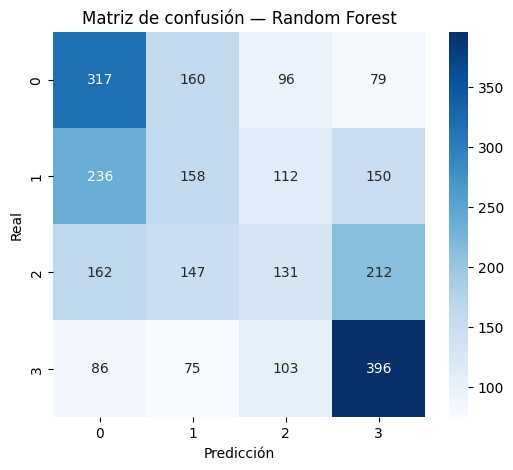

In [14]:
# ============================================================
# 8. Validación
# ============================================================

preds = rf.predict(X_val_enc)
acc = accuracy_score(y_val, preds)

print("Accuracy en validación:", acc)

# Matriz de confusión
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión — Random Forest")
plt.show()


In [15]:
# ============================================================
# 9. Entrenar modelo FINAL (todo el train)
# ============================================================

preprocessor.fit(X)  # rehacer para todo el train
X_full_enc = preprocessor.transform(X)

rf_final = RandomForestClassifier(
    n_estimators=150,
    max_depth=18,
    min_samples_split=10,
    n_jobs=-1,
    random_state=42
)

print("Entrenando modelo FINAL...")
rf_final.fit(X_full_enc, y)
print("Modelo final entrenado.")


Entrenando modelo FINAL...
Modelo final entrenado.


In [16]:
# ============================================================
# 10. Cargar test_clean.csv
# ============================================================

test = pd.read_csv("test_clean.csv")
print("test_clean.csv cargado. Shape:", test.shape)


test_clean.csv cargado. Shape: (238001, 70)


In [17]:
# ============================================================
# 11. Alinear columnas de test
# ============================================================

test = test[X.columns]  # mismas columnas que X
print("Test alineado. Shape:", test.shape)


Test alineado. Shape: (238001, 70)


In [20]:
# ============================================================
# 6. Generación de submission para Kaggle
# ============================================================

print("Generando predicciones para test...")

# Transformar test final con el preprocesador YA entrenado
test_enc = preprocessor.transform(test)

# Predicciones del modelo entrenado
preds_test = rf_final.predict(test_enc)

# Convertir a enteros para evitar errores de mapeo
preds_test_int = preds_test.astype(float).astype(int)

# Diccionario de mapeo según tu orden
inv = {
    0: "bajo",
    1: "medio-bajo",
    2: "medio-alto",
    3: "alto"
}

# Convertir las predicciones numéricas a etiquetas
preds_text = [inv[p] for p in preds_test_int]

# Crear archivo final
submission = pd.DataFrame({
    "ID": test["ID"],
    "RENDIMIENTO_GLOBAL": preds_text
})

submission.to_csv("submission_rf.csv", index=False)
print("¡Archivo submission_rf.csv generado correctamente!")


Generando predicciones para test...
¡Archivo submission_rf.csv generado correctamente!


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# =====================================================
# 1. Cargar datos
# =====================================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train:", train.shape)
print("Test:", test.shape)

# =====================================================
# 2. Separar X y y
# =====================================================
y = train["RENDIMIENTO_GLOBAL"]
X = train.drop(columns=["RENDIMIENTO_GLOBAL"])

X_test = test.copy()

# =====================================================
# 3. Identificar columnas
# =====================================================
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

# =====================================================
# 4. Preprocesador
# =====================================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# =====================================================
# 5. Modelo
# =====================================================
model = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=18,
        random_state=42,
        n_jobs=-1
    ))
])

print("Entrenando modelo...")
model.fit(X, y)

# =====================================================
# 6. Predicciones sobre test
# =====================================================
print("Generando predicciones...")
preds = model.predict(X_test)

# =====================================================
# 7. Crear archivo submission
# =====================================================
submission = pd.DataFrame({
    "ID": test["ID"],
    "RENDIMIENTO_GLOBAL": preds
})

print("Submission shape:", submission.shape)
submission.to_csv("submission_final.csv", index=False)

print("Archivo generado: submission_final.csv")


Train: (692500, 21)
Test: (296786, 20)
Entrenando modelo...
Generando predicciones...
Submission shape: (296786, 2)
Archivo generado: submission_final.csv
